# LANL Earthquake Prediction

## Get Data:

To get the data, we only have to download it from the database and open it, altough there was to much data, thus, I splitted the data into 4196 csv files of 150000 rows each

In [1]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os


# define constants
DATA_DIR = "data/"
TRAIN_DIR = "data/train/"
MODELS_DIR = "models/"
TEST_DIR = os.path.join(DATA_DIR, "test/")


# load data into dataframe
train_files = os.listdir(TRAIN_DIR);
train_files.sort()
LANL_train_set = pd.read_csv(os.path.join(TRAIN_DIR, train_files[42]))
LANL_train_array = np.array(LANL_train_set['acoustic_data'])
LANL_train_labels = np.array(LANL_train_set['time_to_failure'])
LANL_mean = np.mean(LANL_train_array)
LANL_std  = np.std(LANL_train_array)
LANL_variance = np.var(LANL_train_array)

## Analize Data:

First of all, lets plot the head of the data into our notebook, tyo see an example of what we are working with

In [2]:
LANL_train_set.head()

,acoustic_data,time_to_failure
0,8,11.3737
1,8,11.3737
2,3,11.3737
3,3,11.3737
4,1,11.3737


Now, let's plot all the acoustic data to have a more visual representation of it. For this, I made a function that generates different plots we can use such as an histogram and a boxplot

In [3]:
def gen_plots(x):
    n_bins = 70
    rows = 3
    cols = 1
    plt.figure(1, figsize=(7, 15))
    # plot data
    plt.subplot(rows, cols, 1)
    plt.plot(x)
    
    # plot histogram
    hist = plt.subplot(rows, cols, 2)
    hist.set_title("Histogram")
    n, bins, patches = plt.hist(x, n_bins, facecolor='orange', alpha=0.5)
    
    # plot boxplot
    boxplot = plt.subplot(rows, cols, 3)
    plt.boxplot(x)
    boxplot.set_title("Boxplot")
    plt.show()


Next we generate the different plots, we can see form the histogram that the instance follows a normal distribution and the most of the values are positive, this may vary from instance to instace, altought all of them a similar distribition. 

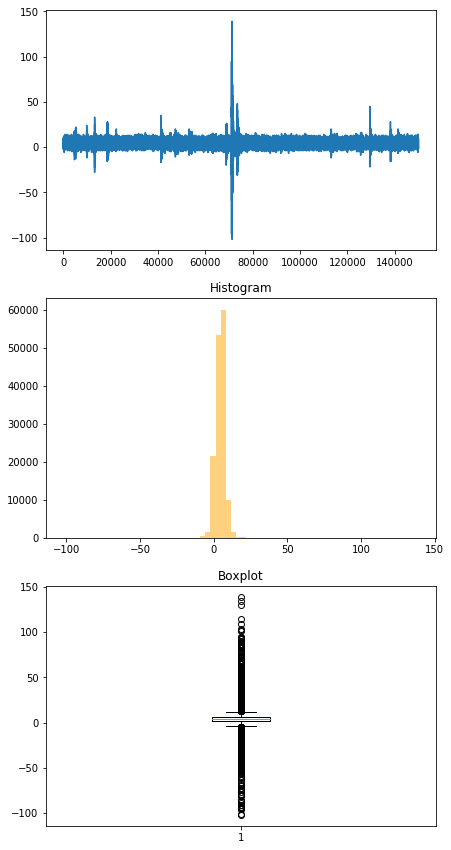

In [4]:
gen_plots(LANL_train_array)

The data we are using right represents only a single intance wich is a time segment with only one label. With this instance we might neeed to do some feature engeneering. Let's see some example of qualities we can get from the instance and its label. From this data, I concluded that we can use the mean of all the failure times from the instance as the single label for the instance.

In [5]:
print("Mean: ", LANL_mean)
print("Standard deviation: ", LANL_std)
print("Variance: ", LANL_variance)
print("Time to failure mean: ", np.mean(LANL_train_labels))
print("Max time to failure: ", np.max(LANL_train_labels))
print("Min time to failure: ", np.min(LANL_train_labels))

Mean:  4.3839733333333335
Standard deviation:  4.22277844702066
Variance:  17.83185781262222
Time to failure mean:  11.354673242272735
Max time to failure:  11.373699597
Min time to failure:  11.335396800000002


We can see we are starting to make new features for this instance, let's save it in a pandas dataframe 

In [6]:
features = np.array([LANL_mean, LANL_std, LANL_variance])
LANL_train = pd.DataFrame({'mean' : [features[0]], 'deviation' : [features[1]], 'variance' : features[2]})

In [7]:
LANL_train

,mean,deviation,variance
0,4.383973,4.222778,17.831858


Now we have a nice way to store all the features for each instance. But it seems a bit deorganized and once we start adding functions and features it will get more complicated; so let's make a simple pipeline to automatize all the process. For this I created a list of functions to make each feature and an estimator that applies each function to the instance. 

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import skew, kurtosis

cv =  lambda x: np.std(x) / np.mean(x)


# feature functions
feature_names = ['mean', 'deviation', 'variance', 
                 'min', 'max', 'skewness',
                 'kurtosis', 'quantile_25', 'quantile_50',
                 'quantile_75', 'q95', 'q99', 'q05', 'q01', 'abs_q95', 
                 'abs_q99', 'abs_q05', 'abs_q01', 'coeficient__of_variation',
                 'std_first_50000', 'std_last_50000', 'std_first_10000', 'std_last_10000',
                 'avg_first_50000', 'avg_last_50000', 'avg_first_10000', 'avg_last_10000',
                 'min_first_50000', 'min_last_50000', 'min_first_10000', 'min_last_10000',
                 'max_first_50000', 'max_last_50000', 'max_first_10000', 'max_last_10000']
for window in ['10', '100', '1000']:
    feature_names.append('ave_roll_std_' + window)
    feature_names.append('std_roll_std_' + window)
    feature_names.append('max_roll_std_' + window)
    feature_names.append('min_roll_std_' + window)
    feature_names.append('q01_roll_std_' + window)
    feature_names.append('q05_roll_std_' + window)
    feature_names.append('q95_roll_std_' + window)
    feature_names.append('q99_roll_std_' + window)
    feature_names.append('av_change_abs_roll_std_' + window)
    feature_names.append('abs_max_roll_std_' + window)
    feature_names.append('ave_roll_mean_' + window)
    feature_names.append('std_roll_mean_' + window)
    feature_names.append('max_roll_mean_' + window)
    feature_names.append('min_roll_mean_' + window)
    feature_names.append('q01_roll_mean_' + window)
    feature_names.append('q05_roll_mean_' + window)
    feature_names.append('q95_roll_mean_' + window)
    feature_names.append('q99_roll_mean_' + window)
    feature_names.append('av_change_abs_roll_mean_' + window)
    feature_names.append('abs_max_roll_mean_' + window)
    
feature_trans = {'mean' : np.mean, 'deviation' : np.std, 'variance' : np.var, 
                 'min' : np.min, 'max' : np.max, 'skewness' : skew,
                 'kurtosis' : kurtosis, 'quantile' : np.quantile, 'coeficient__of_variation' : cv}

class FeatureGenerator(BaseEstimator, TransformerMixin):
   
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        features = []
        for name in feature_trans:
            if name == 'quantile':
                features.append(feature_trans[name](X, .25))
                features.append(feature_trans[name](X, .50))
                features.append(feature_trans[name](X, .75))
                features.append(feature_trans[name](X, 0.95))
                features.append(feature_trans[name](X, 0.99))
                features.append(feature_trans[name](X, 0.05))
                features.append(feature_trans[name](X, 0.01))
                features.append(feature_trans[name](np.abs(X), 0.95))
                features.append(feature_trans[name](np.abs(X), 0.99))
                features.append(feature_trans[name](np.abs(X), 0.05))
                features.append(feature_trans[name](np.abs(X), 0.01))
            else:
                features.append(feature_trans[name](X))
        features.append(np.mean(X[:50000]))
        features.append(np.mean(X[50000:]))
        features.append(np.mean(X[:10000]))
        features.append(np.mean(X[10000:]))
        features.append(np.std(X[:50000]))
        features.append(np.std(X[50000:]))
        features.append(np.std(X[:10000]))
        features.append(np.std(X[10000:]))
        features.append(np.min(X[:50000]))
        features.append(np.min(X[50000:]))
        features.append(np.min(X[:10000]))
        features.append(np.min(X[10000:]))
        features.append(np.max(X[:50000]))
        features.append(np.max(X[50000:]))
        features.append(np.max(X[:10000]))
        features.append(np.max(X[10000:]))
        X = pd.Series(X)
        for windows in [10, 100, 1000]:
            x_roll_std = X.rolling(windows).std().dropna().values
            x_roll_mean = X.rolling(windows).mean().dropna().values
            features.append(x_roll_std.mean())
            features.append(x_roll_std.std())
            features.append(x_roll_std.max())
            features.append(x_roll_std.min())
            features.append(np.quantile(x_roll_std, 0.01))
            features.append(np.quantile(x_roll_std, 0.05))
            features.append(np.quantile(x_roll_std, 0.95))
            features.append(np.quantile(x_roll_std, 0.99))
            features.append(np.mean(np.diff(x_roll_std)))
            features.append(np.abs(x_roll_std).max())
            features.append(x_roll_mean.mean())
            features.append(x_roll_mean.std())
            features.append(x_roll_mean.max())
            features.append(x_roll_mean.min())
            features.append(np.quantile(x_roll_mean, 0.01))
            features.append(np.quantile(x_roll_mean, 0.05))
            features.append(np.quantile(x_roll_mean, 0.95))
            features.append(np.quantile(x_roll_mean, 0.99))
            features.append(np.mean(np.diff(x_roll_mean)))
            features.append(np.abs(x_roll_mean).max())
        return np.c_[features]

Now let's generate the features for all the instances in the dataset. The following function automates all the process from getting the data, appaying the function and finally normalazing it. 

In [9]:
from sklearn.preprocessing import StandardScaler

def GetTrainInstances(max_inst=-1, directory=TRAIN_DIR, normalize=True, log=False):
    LANL_X = []
    LANL_y = []
    i = 0

    gen = FeatureGenerator()
    scaler = StandardScaler()
    max_instances = max_inst
    print("Progress:")
    for file in train_files:
        if i == max_instances:
            break
        if i % 42 == 0:
            print(int(i / 42), end='.')
        tmp = pd.read_csv(os.path.join(directory, file))
        tmp_data = np.array(tmp['acoustic_data'])
        tmp_labels = np.array(tmp['time_to_failure'])
        if log:
            for element in tmp_data:
                if element < 0:
                    element = -np.log10(abs(element))
                elif element > 0:
                    element = np.log10(element)
        LANL_X.append(gen.fit_transform(tmp_data))
        # for all time instances we get the mean
        LANL_y.append(np.mean(tmp_labels)) 
        i += 1
    if normalize:
        LANL_X = scaler.fit_transform(np.array(LANL_X).reshape(max_instances, len(feature_names)))
    LANL_X = pd.DataFrame(np.array(LANL_X).reshape(max_instances, len(feature_names)), columns=feature_names)
    LANL_y = pd.DataFrame(np.array(LANL_y).reshape(max_instances, 1), columns=['time_to_failure'])
    LANL_X.to_csv(os.path.join(DATA_DIR, "train_data.csv"), sep=',', encoding='utf-8', index=False)
    LANL_y.to_csv(os.path.join(DATA_DIR, "train_labels.csv"), sep=',', encoding='utf-8', index=False)
    return LANL_X, LANL_y
            
    

In [220]:
LANL_X, LANL_y = GetTrainInstances(max_inst=-1, normalize=True, log=False)

Progress:
0.1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.30.31.32.33.34.35.36.37.38.39.40.41.42.43.44.45.46.47.48.49.50.51.52.53.54.55.56.57.58.59.60.61.62.63.64.65.66.67.68.69.70.71.72.73.74.75.76.77.78.79.80.81.82.83.84.85.86.87.88.89.90.91.92.93.94.95.96.97.98.99.

We could also load the dataset that has been generated. 

In [10]:
LANL_X = pd.read_csv(os.path.join(DATA_DIR, "train_data.csv"))
LANL_y = pd.read_csv(os.path.join(DATA_DIR, "train_labels.csv"))

For now I only loaded 200 instances of the dataset because it is easier to work with. When we start training the model I will include all the dataset

In [11]:
LANL_X.head()

,mean,deviation,variance,min,max,skewness,kurtosis,quantile_25,quantile_50,quantile_75,...,ave_roll_mean_1000,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,abs_max_roll_mean_1000
0,1.424140,-0.170214,-0.080583,0.193218,-0.218194,-0.313703,-0.491310,1.594316,0.947037,0.288822,...,1.421036,0.268470,-0.004742,0.178278,0.287332,0.965402,1.509153,0.885262,-0.631300,-0.004742
1,0.805716,0.004734,-0.064868,-0.018037,0.063936,0.553891,0.431696,-0.405852,0.947037,0.288822,...,0.802052,-0.141264,0.007341,-0.025387,0.622391,0.842747,0.522428,0.294357,-0.912054,0.007341
2,1.511155,0.049252,-0.060230,0.163039,-0.086289,0.191534,-0.492831,-0.405852,0.947037,0.288822,...,1.508574,0.085078,0.099556,0.245184,0.634878,1.207106,1.530919,0.889790,0.441128,0.099556
3,1.494934,0.043950,-0.060796,-0.187796,0.122560,1.321245,0.683938,-0.405852,0.947037,0.288822,...,1.491578,0.083085,0.068076,0.105059,0.770151,1.160208,1.432972,0.815078,-0.949994,0.068076
4,1.520242,0.088495,-0.055927,0.087590,-0.067969,-0.128324,-0.217434,-0.405852,0.947037,0.288822,...,1.525581,-0.164151,0.138032,0.187535,1.040695,1.557034,1.393068,0.901110,0.595416,0.138032


Now let's try to find out more information about the dataset looking at the correlation of the features

In [12]:
LANL_X.shape

(4194, 95)

With what we have now let's divide the data into training set and testing set

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(np.array(LANL_X), np.array(LANL_y), test_size=0.2, random_state=42)

In [14]:
y_train.shape

(3355, 1)

Before going any further I want to make a function that makes predictions and saves them for upload to kaggle

In [185]:
def MakeSubmission(model):
    col_names = ['seg_id', 'time_to_failure']
    sub  = pd.DataFrame(columns = col_names)
    gen = FeatureGenerator()
    scaler = StandardScaler()
    for i, file in enumerate(os.listdir(TEST_DIR)):
        if i % 26 == 0:
            print(int(i / 26), end='.')
        tmp = pd.read_csv(os.path.join(TEST_DIR, file))
        tmp_data = np.array(tmp['acoustic_data'])
        d = gen.fit_transform(tmp_data)
        scaler.fit_transform(d)
        pred = model.predict(d.reshape(1, -1))
       # print(pred)
        sub.loc[i] = [file[:-4], pred[0]]
        
    sub.to_csv("submission.csv", sep=',', encoding='utf-8', index=False)
        

Wwe also need a method to validate how good our model is 

In [177]:
from sklearn.model_selection import cross_val_score

def display_scores(model, X, y):
    scores = cross_val_score(model, X, y.reshape(-1), 
                             scoring="neg_mean_absolute_error", cv=10)
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

## Training

Now let's see how well a model performs. I uses a random forest because I like them and not for anything in particular, altough later we will need to test a lot of models and select a few promising

### Random Forest

In [180]:
from sklearn.ensemble import RandomForestRegressor

model_rfr = RandomForestRegressor(n_estimators=10, criterion="mae", 
                                    random_state=42, n_jobs=-1)

In [181]:
model_rfr.fit(X_train, y_train.reshape(-1))

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

Before going any further let's save our model

In [26]:
from sklearn.externals import joblib

joblib.dump(model_rfr, os.path.join(MODELS_DIR, "model_rfr.pkl"))

['models/model_rfr.pkl']

Instead of fitting and creating our model let's load it 

In [27]:
from sklearn.externals import joblib

model_rfr = joblib.load(os.path.join(MODELS_DIR, "model_rfr.pkl"))

Now that we have trained the random forest regressor, let's find out the feature importances. As we can see the deviation is the feature that has the most importance, altought it does not have to much importance only 20% 

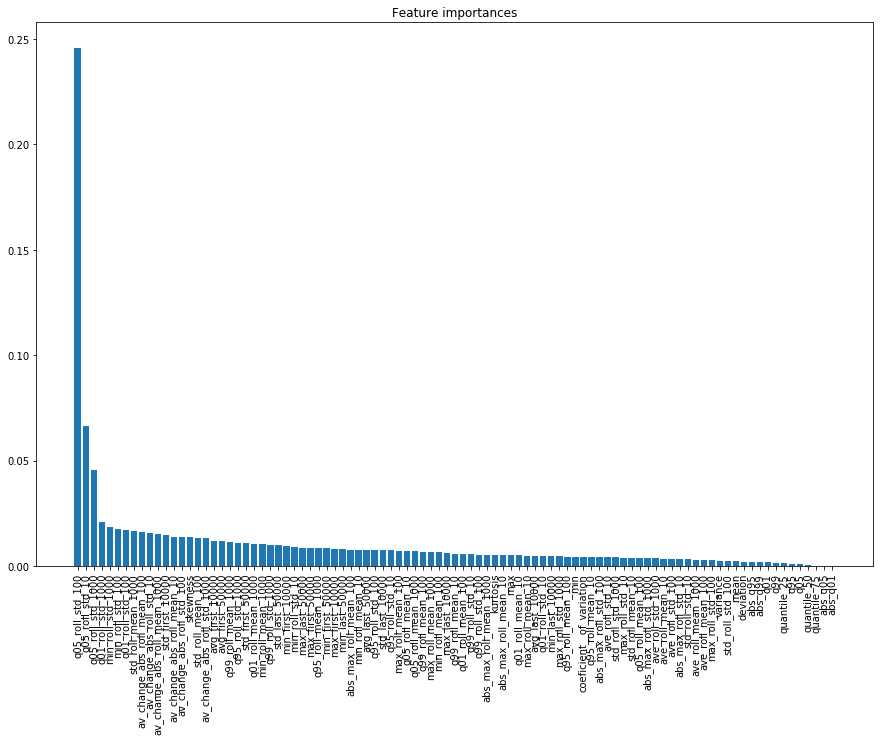

In [182]:
# calculate feature importances
importances = model_rfr.feature_importances_

# sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# rearrange feature names so that they match the sorted feature importances
names = [feature_names[i] for i in indices]

# create plot
plt.figure(figsize=(15,10))
plt.title("Feature importances")

# add bars
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), names, rotation=90)

# show plot
plt.show()

Let's make a simple prediction of our selected testing test

In [183]:
display_scores(model_rfr, X_test, y_test.reshape(-1))

Scores: [-2.19815893 -2.59896494 -2.40093462 -2.553712   -2.23454397 -1.9843262
 -1.76335127 -1.82442886 -2.57385895 -2.32658444]
Mean: -2.245886417829999
Standard deviation: 0.2896249457909597


In [186]:
MakeSubmission(model_rfr)

0.1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.30.31.32.33.34.35.36.37.38.39.40.41.42.43.44.45.46.47.48.49.50.51.52.53.54.55.56.57.58.59.60.61.62.63.64.65.66.67.68.69.70.71.72.73.74.75.76.77.78.79.80.81.82.83.84.85.86.87.88.89.90.91.92.93.94.95.96.97.98.99.100.

In [192]:
pd.read_csv("submission.csv")['time_to_failure'].max()

3.4698621155909626

In [193]:
pd.read_csv("submission_rfr.csv")['time_to_failure'].max()

6.089413795655777

 Mean absolute error: 2.1865890105510672

### Linear Regression

In [33]:
from sklearn.linear_model import LinearRegression

model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [34]:
display_scores(model_lr, X_test, y_test.reshape(-1))

Scores: [-2.62498599 -2.64621591 -2.51774725 -2.53027344 -2.73145609 -2.4634866
 -2.35052769 -2.22337638 -4.20220734 -2.29119617]
Mean: -2.6581472861277686
Standard deviation: 0.5369360321729015


### Stochastic Gradient Descent

In [45]:
from sklearn.linear_model import SGDRegressor

model_sgd = SGDRegressor(max_iter=50, tol=-np.infty, penalty=None, eta0=0.1, random_state=42)

In [47]:
model_sgd.fit(X_train, y_train.reshape(-1))

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.1, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=50,
       n_iter=None, n_iter_no_change=5, penalty=None, power_t=0.25,
       random_state=42, shuffle=True, tol=-inf, validation_fraction=0.1,
       verbose=0, warm_start=False)

In [49]:
display_scores(model_sgd, X_test, y_test.reshape(-1))

Scores: [-1.28295374e+11 -1.16309139e+11 -1.87637484e+11 -2.39937309e+11
 -1.79393570e+11 -2.60018022e+11 -2.34475151e+11 -2.28906148e+11
 -2.61670855e+11 -1.67937866e+11]
Mean: -200458091691.2497
Standard deviation: 49773084923.24586


### Neural Network


In [139]:
def MakeSubmissionDNN(model):
    col_names = ['seg_id', 'time_to_failure']
    sub  = pd.DataFrame(columns = col_names)
    gen = FeatureGenerator()
    scaler = StandardScaler()
    for i, file in enumerate(os.listdir(TEST_DIR)):
        #if i % 26 == 0:
        #    print(int(i / 26), end='.')
        tmp = pd.read_csv(os.path.join(TEST_DIR, file))
        tmp_data = np.array(tmp['acoustic_data'])
        d = gen.fit_transform(tmp_data)
        scaler.fit_transform(d)
        pred = model.predict(d.reshape(1, -1))
        print(pred[0][0])
        if pred[0][0] < 0:
            print("ERROR")
            exit(1)
        sub.loc[i] = [file[:-4], pred[0][0]]
        
    sub.to_csv("submission.csv", sep=',', encoding='utf-8', index=False)
        

In [163]:
import tensorflow as tf
from keras import models
from keras import layers
from keras import optimizers
from keras import initializers
from keras import regularizers
from keras import activations 
from keras.layers.normalization import BatchNormalization

model_dnn = models.Sequential()

# input layer
model_dnn.add(layers.Dense(units=200,
                           activation=activations.elu, 
                           input_shape=(LANL_X.shape[1],),
                           kernel_initializer=initializers.he_normal(seed=1),
                           kernel_regularizer=regularizers.l2(0.01)))

# hidden layer
model_dnn.add(layers.Dense(units=200,
                           activation=activations.elu,
                           kernel_initializer=initializers.he_normal(seed=1),
                           kernel_regularizer=regularizers.l2(0.01)))
model_dnn.add(layers.Dropout(0.5))


# hidden layer
model_dnn.add(layers.Dense(units=200,
                           activation=activations.elu,
                           kernel_initializer=initializers.he_normal(seed=1),
                           kernel_regularizer=regularizers.l2(0.01)))
model_dnn.add(layers.Dropout(0.5))


# hidden layer
model_dnn.add(layers.Dense(units=200,
                           activation=activations.elu,
                           kernel_initializer=initializers.he_normal(seed=1),
                           kernel_regularizer=regularizers.l2(0.01)))
model_dnn.add(layers.Dropout(0.5))


# hidden layer
model_dnn.add(layers.Dense(units=200,
                           activation=activations.elu,
                           kernel_initializer=initializers.he_normal(seed=1),
                           kernel_regularizer=regularizers.l2(0.01)))
model_dnn.add(layers.Dropout(0.5))


# hidden layer
model_dnn.add(layers.Dense(units=200,
                           activation=activations.elu,
                           kernel_initializer=initializers.he_normal(seed=1),
                           kernel_regularizer=regularizers.l2(0.01)))
model_dnn.add(layers.Dropout(0.5))


# output layer
model_dnn.add(layers.Dense(units=1))

              
optimizer = optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=None, decay=0.0)
model_dnn.compile(loss="mae", 
                  optimizer=optimizer,
                  metrics=["mae"])
              


In [164]:
from keras.callbacks import EarlyStopping

callbacks = [EarlyStopping(monitor="val_loss", patience=2)]

history = model_dnn.fit(np.array(LANL_X),
                        np.array(LANL_y).reshape(-1),
                        epochs=200,
                        verbose=1,
                        batch_size=50,
                        validation_split=0.2,
                        shuffle=True,
                        callbacks=callbacks)

Train on 3355 samples, validate on 839 samples
Epoch 1/200
3355/3355 [==============================] - 6s 2ms/step - loss: 30.4027 - mean_absolute_error: 6.4984 - val_loss: 27.2579 - val_mean_absolute_error: 3.4495
Epoch 2/200
3355/3355 [==============================] - 0s 110us/step - loss: 29.3416 - mean_absolute_error: 5.6226 - val_loss: 27.0526 - val_mean_absolute_error: 3.4299
Epoch 3/200
3355/3355 [==============================] - 0s 105us/step - loss: 28.9002 - mean_absolute_error: 5.3688 - val_loss: 26.7558 - val_mean_absolute_error: 3.3230
Epoch 4/200
3355/3355 [==============================] - 0s 112us/step - loss: 28.2342 - mean_absolute_error: 4.8970 - val_loss: 26.6547 - val_mean_absolute_error: 3.4202
Epoch 5/200
3355/3355 [==============================] - 0s 107us/step - loss: 27.7813 - mean_absolute_error: 4.6440 - val_loss: 26.4694 - val_mean_absolute_error: 3.4361
Epoch 6/200
3355/3355 [==============================] - 0s 115us/step - loss: 27.3726 - mean_absolu

3355/3355 [==============================] - 0s 116us/step - loss: 3.8789 - mean_absolute_error: 2.1321 - val_loss: 3.7087 - val_mean_absolute_error: 2.0039
Epoch 97/200
3355/3355 [==============================] - 0s 126us/step - loss: 3.8118 - mean_absolute_error: 2.1448 - val_loss: 3.6189 - val_mean_absolute_error: 1.9912
Epoch 98/200
3355/3355 [==============================] - 0s 134us/step - loss: 3.6936 - mean_absolute_error: 2.1028 - val_loss: 3.5375 - val_mean_absolute_error: 1.9837
Epoch 99/200
3355/3355 [==============================] - 0s 117us/step - loss: 3.6284 - mean_absolute_error: 2.1098 - val_loss: 3.4348 - val_mean_absolute_error: 1.9528
Epoch 100/200
3355/3355 [==============================] - 0s 116us/step - loss: 3.5594 - mean_absolute_error: 2.1079 - val_loss: 3.3884 - val_mean_absolute_error: 1.9691
Epoch 101/200
3355/3355 [==============================] - 0s 116us/step - loss: 3.4777 - mean_absolute_error: 2.0886 - val_loss: 3.3409 - val_mean_absolute_error

Before going any further let's save the model

In [132]:
model_dnn.save("models/model_dnn.h5")

Let's load the pretrained model

In [19]:
model_dnn = models.load_model("models/model_dnn.h5")

Text(0.5, 0, 'Epoch')

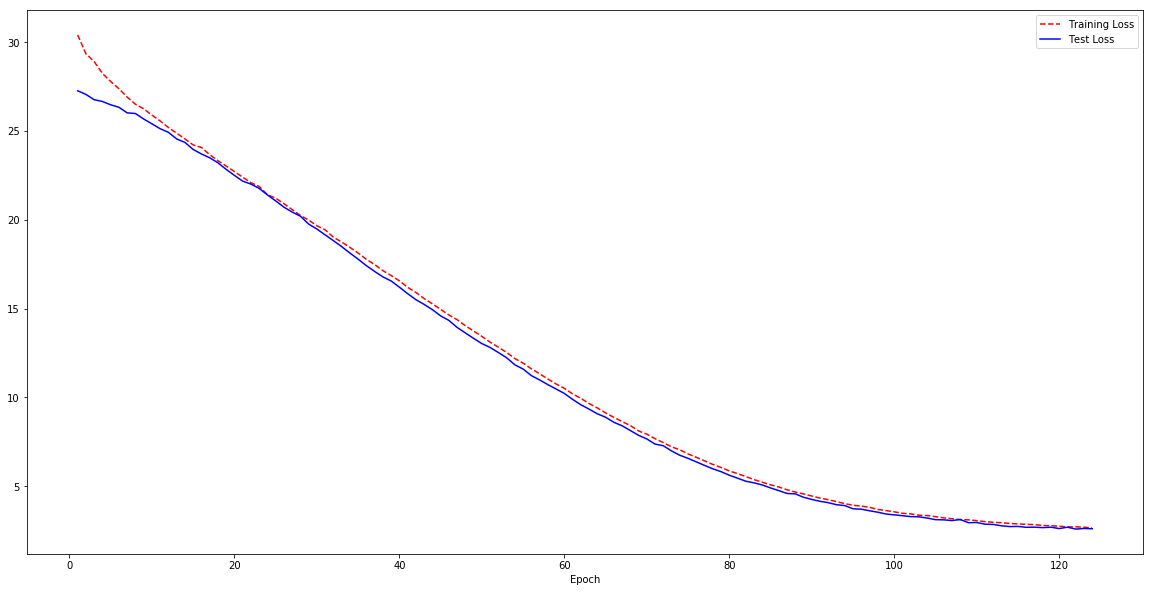

In [165]:
# get loss history
training_loss = history.history["loss"]
test_loss = history.history["val_loss"]

epoch_count = range(1, len(training_loss) + 1)

# visualize loss
plt.figure(figsize=(20,10))
plt.plot(epoch_count, training_loss, "r--")
plt.plot(epoch_count, test_loss, "b-")
plt.legend(["Training Loss", "Test Loss"])
plt.xlabel("Epoch")

Text(0.5, 0, 'Epoch')

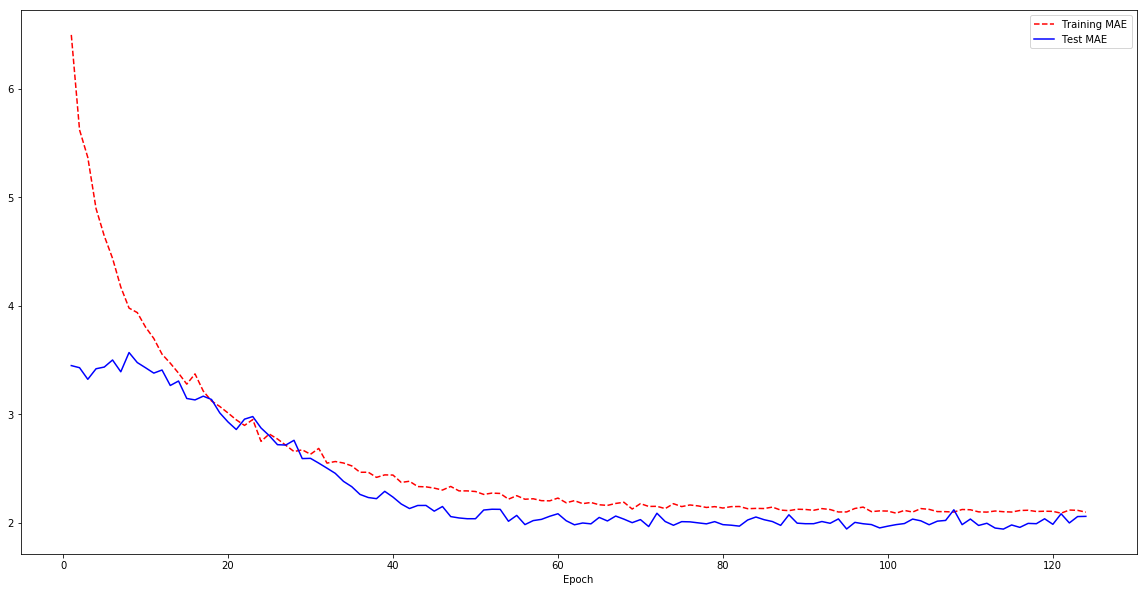

In [166]:
# get loss history
training_error = history.history["mean_absolute_error"]
test_error = history.history["val_mean_absolute_error"]

epoch_count = range(1, len(training_error) + 1)

# visualize loss
plt.figure(figsize=(20,10))
plt.plot(epoch_count, training_error, "r--")
plt.plot(epoch_count, test_error, "b-")
plt.legend(["Training MAE", "Test MAE"])
plt.xlabel("Epoch")

In [167]:
model_dnn.predict(X_test)

array([[ 8.087396  ],
       [ 6.9197326 ],
       [ 6.95923   ],
       [ 7.6798434 ],
       [ 8.836358  ],
       [ 4.116748  ],
       [ 1.2136614 ],
       [ 8.982198  ],
       [ 6.301811  ],
       [ 3.8697891 ],
       [ 2.413628  ],
       [ 1.9977038 ],
       [ 9.082962  ],
       [ 4.6081505 ],
       [ 1.8664026 ],
       [ 8.951219  ],
       [ 4.5206575 ],
       [ 9.4147215 ],
       [ 6.1942015 ],
       [ 2.3058062 ],
       [ 3.434854  ],
       [ 2.2108757 ],
       [ 8.738113  ],
       [ 1.9950815 ],
       [ 6.815847  ],
       [ 3.3236728 ],
       [ 5.2080827 ],
       [ 1.658536  ],
       [ 5.8469434 ],
       [ 5.4932785 ],
       [ 2.0271287 ],
       [ 2.3061066 ],
       [ 6.7094283 ],
       [ 1.6404065 ],
       [ 1.9736959 ],
       [ 2.090872  ],
       [ 8.256342  ],
       [ 2.1712832 ],
       [ 0.11073147],
       [ 5.6548553 ],
       [ 2.2224941 ],
       [ 2.998231  ],
       [ 7.3983073 ],
       [ 3.1434698 ],
       [ 7.8560038 ],
       [ 2

In [168]:
MakeSubmissionDNN(model_dnn)

8.529605
0.51474434
5.866439
4.9285517
2.2452755
5.8471775
4.8348093
7.2806573
7.746618
2.0649176
7.34986
4.3170867
8.804158
10.28867
2.6436749
10.827441
0.5050191
-1.0688059
ERROR
2.5323157
10.682216
3.5584164
4.6939387
1.2663013
4.5725894
1.7830676
3.6437197
0.6024017
2.9027734
1.0386412
5.685667
-2.6521978
ERROR
2.2116778
7.570505
2.8536716
0.523974
11.13931
4.471944
-0.4912486
ERROR
8.434997
15.173155
8.364617
0.46702597
4.907741
-1.5502075
ERROR
3.5120335
9.675801
7.6838627
3.52734
8.392899
2.9738955
13.169304
7.663649
7.624867
4.6430182
-2.815763
ERROR
2.5514197
4.6123185
7.063062
8.361631
4.314547
-0.31315362
ERROR
4.127251
10.220829
5.326561
2.3037663
5.8127637
10.631553
2.2466345
-2.6420941
ERROR
1.7019501
-0.9038253
ERROR
3.2590775
0.8761767


KeyboardInterrupt: 

In [138]:
pd.read_csv("submission.csv")['time_to_failure']

0        8.040995
1        2.920841
2        8.178400
3        7.415175
4        4.939457
5        3.631158
6        3.230819
7        7.042015
8        8.221464
9        3.646047
10       5.527153
11       1.801975
12      10.976599
13       8.632207
14       4.095632
15      11.777329
16       9.935243
17       7.865444
18       5.237314
19      10.833324
20       7.231575
21       3.567306
22       5.228791
23       7.023671
24       5.042724
25       4.912757
26       5.255416
27       3.106389
28       7.611414
29       5.070179
          ...    
2594     5.366967
2595     6.110739
2596     5.128806
2597     5.762695
2598     6.241332
2599     8.156597
2600     6.826262
2601     5.531102
2602     5.313789
2603    17.525909
2604    16.791441
2605     7.705446
2606     7.200379
2607    11.369008
2608     3.653826
2609     4.244637
2610     3.286018
2611     7.358106
2612     4.446157
2613     6.264445
2614     1.977330
2615     5.472434
2616     7.543272
2617    11.528442
2618    14

In [135]:
pd.read_csv("submission_rfr.csv")['time_to_failure'].mean()

2.9648863179877094

### Linear Support Vector Machine

In [279]:
from sklearn.svm import LinearSVR
LinearSVR()
model_svmreg = LinearSVR(epsilon=1.5, max_iter=10000)
model_svmreg.fit(X_train, y_train.reshape(-1))

LinearSVR(C=1.0, dual=True, epsilon=1.5, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=10000,
     random_state=None, tol=0.0001, verbose=0)

In [280]:
display_scores(model_svmreg, X_test, y_test.reshape(-1))

Scores: [-2.40050258 -2.55346107 -2.44900943 -2.60713402 -2.30821717 -2.0332136
 -1.99443742 -1.86688061 -3.02009415 -2.19788771]
Mean: -2.3430837752507223
Standard deviation: 0.3245739039308738


In [281]:
mean_absolute_error(y_test, model_svmreg.predict(X_test))

2.175581718445041

In [282]:
model_svmreg.predict(X_test)

array([ 8.40927777,  7.60328005,  7.0025426 ,  6.77734725,  9.11386149,
        4.6606734 ,  1.59523741,  8.65171838,  6.53658079,  5.22245676,
        2.63771876,  2.93320036,  7.45875419,  4.12564301,  1.09509452,
        9.92905002,  5.29620919,  9.68075314,  6.62169188,  3.5513977 ,
        3.65541234,  2.43025689,  8.97615098,  2.87608319,  7.75430818,
        3.59691045,  4.19874072,  2.36024672,  5.62382457,  5.83683642,
        2.1388318 ,  2.59790381,  6.96562787,  2.54789919,  2.24734583,
        3.69315185,  8.49215955,  2.72642808, -5.1974128 ,  5.71519098,
        2.96020654,  2.94022814,  7.98125889,  3.83984994,  7.3281676 ,
        2.96864971,  8.20597572,  2.11900181,  5.61372937,  1.8996663 ,
        7.85964593,  2.99747244,  6.2276162 ,  5.17321564,  1.42859696,
        7.82966541,  5.0426194 , -8.40340254,  4.98782111, 10.2944273 ,
        8.40051697,  3.2613196 ,  2.61474224,  3.28920299,  7.54022043,
        8.79197504,  9.20554877,  2.30534617,  1.99628965,  3.98

In [260]:
MakeSubmission(model_svmreg)